<a href="https://colab.research.google.com/github/oansari03/DS-Unit-2-Linear-Models/blob/master/Unit2-Module-4-part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Model Building
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# For running this notebook either locally or in colab
import sys

In [ ]:
%%capture
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
# For encoding categorical data
from category_encoders import OneHotEncoder

# NYC Rent

**GOAL:** Improve our model for predicting NYC rent prices.

**Objectives**

- Do one-hot encoding of categorical features
- Do univariate feature selection
- Use scikit-learn to fit Ridge Regression models

# I. Wrangle Data

Create **wrangle function** for **reproducibility**.

In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   parse_dates=['created'],
                   index_col='created').sort_index()
  
  # Remove outlier observations
  df = df[(df['price'] >= np.percentile(df['price'], 0.05)) & 
          (df['price'] <= np.percentile(df['price'], 99.5)) & 
          (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
          (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
          (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
          (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

  # Drop high-cardinality categorical variables
  cutoff = 5
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  return df

df = wrangle(DATA_PATH+'apartments/renthop-nyc.csv')

In [ ]:
df.head()

In [ ]:
df.info()

# II. Split Data

Split **target vector** from **feature matrix**.

In [ ]:
target = 'price'
y = df[target]
X = df.drop(columns=target)

Split data into **training** and **test** sets.

(Use data from April & May 2016 to train. Use data from June 2016 to test.)

In [ ]:
cutoff = '2016-06-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

# III. Establish Baseline

**Note:** This is a **regression** problem because we're predictiong the continuous value `'price'`.

In [ ]:
y_pred = [y_train.mean()] * len(y_train)
print('Mean price:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean price: 3565.095561112848
Baseline MAE: 1203.9726810650523


# IV. Build Models

Combine transformers and predictor with `Pipeline`.

In [ ]:
# # # Step 1: Import your transformer class
# # # We did above ☝️

# # # Step 2: Instantiate your transformer
# ohe = OneHotEncoder(use_cat_names=True)

# # # Step 3: Fit your transformer to the TRAINING data
# ohe.fit(X_train)

# # # Step 4: Transform my training and test data
# XT_train = ohe.transform(X_train)
# XT_test = ohe.transform(X_test)

**Model 2:** Ridge regression (regularization)

In [ ]:
# model_r = Ridge(alpha=1.0)
# model_r.fit(XT_train, y_train)

In [ ]:
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge(alpha=1.0)
)

model_r.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['interest_level'], use_cat_names=True)),
                ('ridge', Ridge())])

# V. Check Metrics

In [ ]:
print('Ridge training MAE:', mean_absolute_error(y_train, model_r.predict(X_train)))
print('Ridge test MAE:', mean_absolute_error(y_test, model_r.predict(X_test)))

Ridge training MAE: 672.0351683623255
Ridge test MAE: 675.6640925954134


# VI. Tune Model

** Interlude: How do you know what the best hyperparameter values are? **

In [ ]:
alphas = np.arange(1.0, 20.5, 0.5)
train_mae = []
test_mae=[]

for a in alphas:
  model_r = make_pipeline(
      OneHotEncoder(use_cat_names=True),
      Ridge(alpha=a)
  )

  model_r.fit(X_train, y_train)
  print('trained with alpha:',a)
  train_mae.append(mean_absolute_error(y_train, model_r.predict(X_train)))
  test_mae.append(mean_absolute_error(y_test, model_r.predict(X_test)))

trained with alpha: 1.0
trained with alpha: 1.5
trained with alpha: 2.0
trained with alpha: 2.5
trained with alpha: 3.0
trained with alpha: 3.5
trained with alpha: 4.0
trained with alpha: 4.5
trained with alpha: 5.0
trained with alpha: 5.5
trained with alpha: 6.0
trained with alpha: 6.5
trained with alpha: 7.0
trained with alpha: 7.5
trained with alpha: 8.0
trained with alpha: 8.5
trained with alpha: 9.0
trained with alpha: 9.5
trained with alpha: 10.0
trained with alpha: 10.5
trained with alpha: 11.0
trained with alpha: 11.5
trained with alpha: 12.0
trained with alpha: 12.5
trained with alpha: 13.0
trained with alpha: 13.5
trained with alpha: 14.0
trained with alpha: 14.5
trained with alpha: 15.0
trained with alpha: 15.5
trained with alpha: 16.0
trained with alpha: 16.5
trained with alpha: 17.0
trained with alpha: 17.5
trained with alpha: 18.0
trained with alpha: 18.5
trained with alpha: 19.0
trained with alpha: 19.5
trained with alpha: 20.0


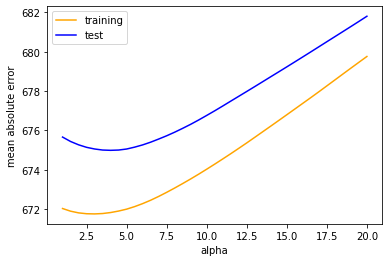

In [ ]:
plt.plot(alphas, train_mae, color='orange', label='training')
plt.plot(alphas, test_mae, color='blue', label='test')
plt.xlabel('alpha')
plt.ylabel('mean absolute error')
plt.legend();

# VII. Communicate results

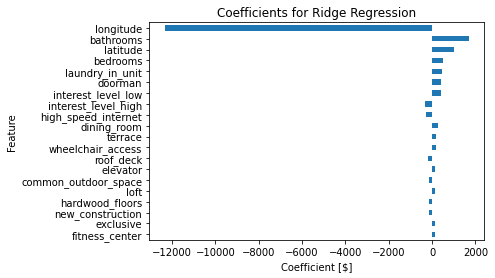

In [ ]:
coefficients = model_r.named_steps['ridge'].coef_
features = model_r.named_steps['onehotencoder'].get_feature_names()
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(20).plot(kind='barh')
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression');